# LDA with `tfp` built-in Hamiltonian Markov-Chain-Monte-Carlo (HMC) Methods

This Notebook presents how TensorFlow Probability's builtin HMC sampling tools can be applied to Latent Dirichlet Allocation. Tested with `tf 2.10` alongside `tfp 0.18.0` on GPU and `tf 2.11` alongside `tfp 0.19.0` on CPU (both Windows).

---

## Setup

In [69]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [70]:
## from ../src
import sys
if "../" not in sys.path: sys.path.append("../")

import src.utils   as tpc_utils # `tpc` abbreviates "topic"
import src.data    as tpc_data
import src.sampler as tpc_sampler

---

## Data Generation
Configurations of the dataset

In [71]:
N_docs       = 300
sqrt_N_vocab = 3
N_words      = 50

## Variable Document Lengths?
uniform_doclengths = False

N_topics = int(2*sqrt_N_vocab)
N_vocab  = int(sqrt_N_vocab**2)

Sampling a dataset with fixed document length or with varying document lengths

In [72]:
data = tpc_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words=N_words,
    uniform_doclengths=uniform_doclengths)

In [73]:
Theta, Pi, C_DId, C_DIdK, words = data.extract_params()

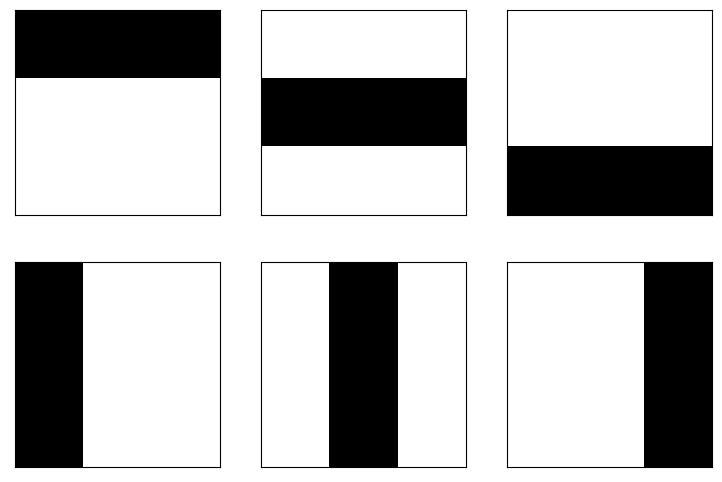

In [74]:
_ = tpc_utils.visualize_topics(Theta, N_row=2, N_col=3)

#### Preprocessing the Data

If the document length is variable, `tfp` methods are not properly applicable, because it lacks capabilities for processing `tf.RaggedTensor`s (as far as I can tell, 2022-11-15). Thus no (joint)-distribution can be defined which samples variable-length documents. The idea is, to pad each document to the size of the longest document base on the observed frequency of each token in the document in a catrgorical-distributed manner:

$$
    X_{\textsf{pad}}^{(j)} \overset{\textsf{iid}}{\sim} \textsf{Categorcial}\left( \frac{\textsf{count}(x_i)}{\textsf{len}(\textsf{doc}_j)}; \ i =1,\dots, V \right)
$$

This should work becaus topic models are bag-of-words models where only the (relative) frequency of token occurances matter. This approach will improve in performace the more word per document are used.

In [75]:
if not uniform_doclengths:
    pad_token = N_vocab + 1
    single_doclengths = words.nested_row_lengths()[0].numpy()
    N_words = tf.reduce_max(single_doclengths)

    words_ragged = words.to_tensor(N_vocab+1).numpy() # Renaming the previous words object.
    words = []

    def pad_single_doc(doc, length, N_words_max=N_words):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(words_ragged, single_doclengths):
        words.append(pad_single_doc(doc, length))
    
    words = tf.constant(words, dtype=tf.int32)

---

## Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2*\sqrt{V} \in \mathbb N$.

The "$C$-step" can be "integrated out" using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).

`tfp` provides multiple ways of defining joints. We use 2 of them (choose by setting the `auto_bached` setting upfront).

In [76]:
## Priors:
alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)      
## Joint
joint = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
        W     = lambda Pi, Theta: tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=Pi),
                components_distribution=tfd.Categorical(probs=Theta)),
            sample_shape=N_words)),
    batch_ndims=0,
    use_vectorized_map=True)

Testing the Joint

In [77]:
## Sampling behavior 
sample = joint.sample()
for key, val in sample.items():
    print(f"Joint Sample Shape {key}: {val.shape}")
## Log-probability of observed (possibly padded data) assuming the joint
p = joint.log_prob(W=words, Pi=Pi, Theta=Theta).numpy()
p_sample = joint.log_prob(W=sample['W'], Pi=sample['Pi'], Theta=sample['Theta']).numpy()
print(f"Log-Probability of the observed data: {p}")
print(f"Log-Probability of the sample from the joint: {p_sample}")

Joint Sample Shape Theta: (6, 9)
Joint Sample Shape Pi: (300, 6)
Joint Sample Shape W: (300, 74)
Log-Probability of the observed data: -43816.58203125
Log-Probability of the sample from the joint: -45987.359375


Presenting documents [147 180 290 132  76 118   4  67 254  92]


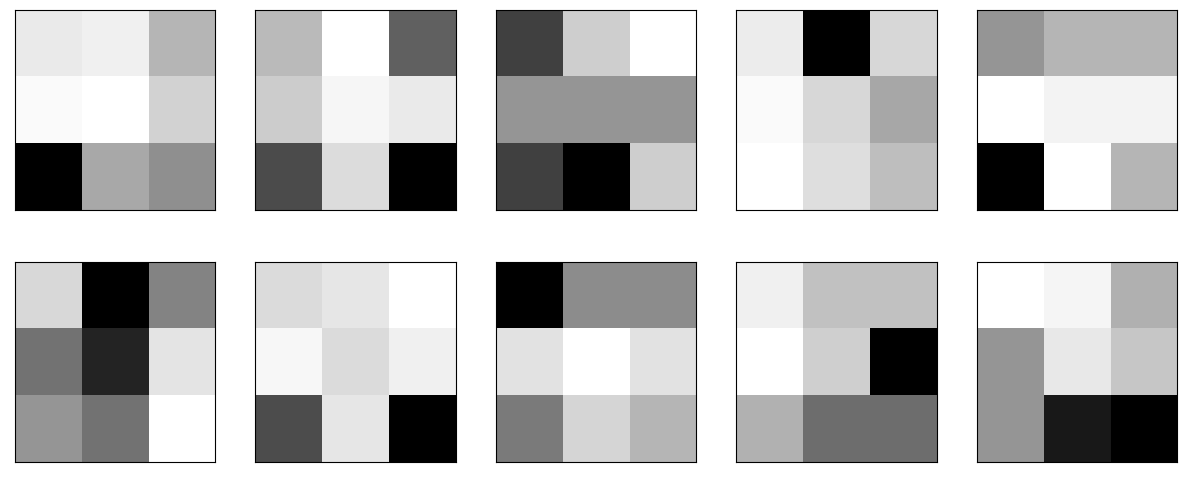

In [78]:
## Visualize documents from the prior-joint
_ = tpc_utils.visualize_random_docs(words, sqrt_V=sqrt_N_vocab)

### Defining the unnormalized Posterior by introducing the Data:

In [79]:
def unnormalized_posterior(Pi, Theta):
    return joint.log_prob(W=words, Pi=Pi, Theta=Theta) # Incorporate data with "words"

---

## HMC-Chain

Orientation was provided here: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo.

In [80]:
## tf-magic
tf.config.experimental.enable_tensor_float_32_execution(False)

In [81]:
## Constraining the Dirichlet-Samples to discrete probability vectors
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered()]

In [82]:
# Create an HMC TransitionKernel
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior,
            step_size=0.065,
            num_leapfrog_steps=5),
    bijector=unconstraining_bijectors),
    num_adaptation_steps=400)

In [83]:
# We wrap sample_chain in tf.function
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=1000):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [84]:
init_pis    = tf.ones_like(Pi, dtype=tf.float32)
init_thetas = tf.ones_like(Theta, dtype=tf.float32)
initial_state = [init_pis, init_thetas]

samples, is_accepted = run_chain(initial_state)

In [85]:
print("Acceptance rate:", tf.reduce_sum(tf.cast(is_accepted, dtype=tf.int16)/is_accepted.shape[0]).numpy())

Acceptance rate: 0.547


In [86]:
Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)

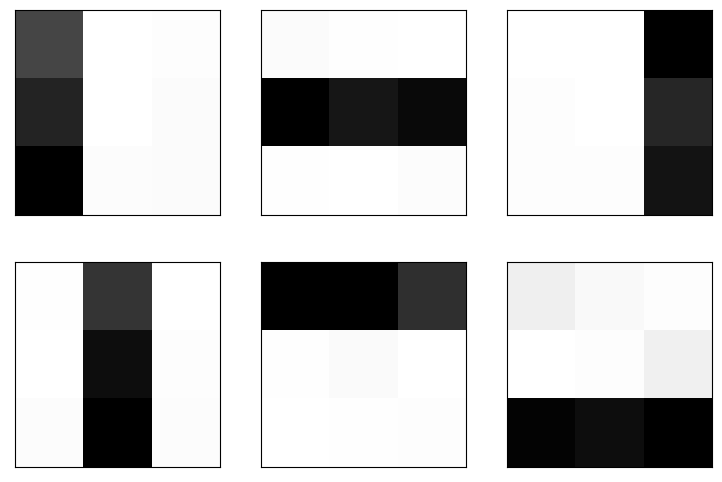

In [87]:
_ = tpc_utils.visualize_topics(Theta_fit, N_row=2, N_col=3)

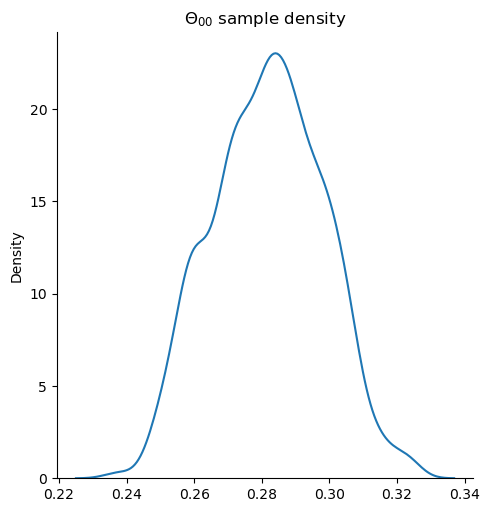

In [88]:
Theta_00 = samples[1][:, 0, 0].numpy()
_ = sns.displot(
    Theta_00, 
    kind="kde"
).set(
    title="$\Theta_{00}$ sample density"
)

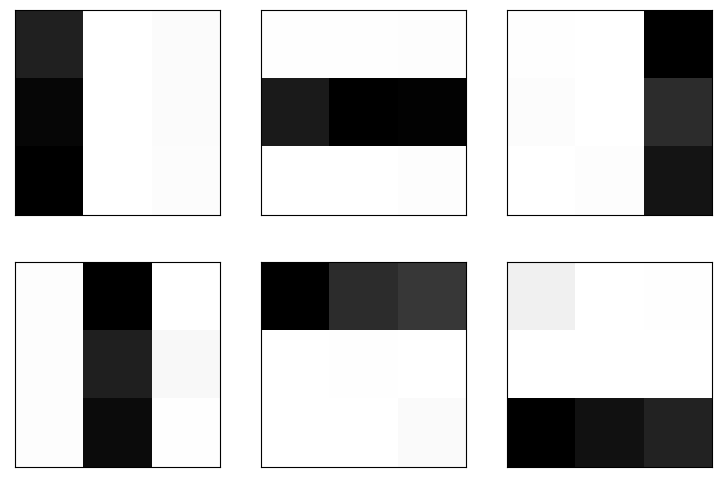

In [89]:
## Is is also possible to train on after initial training by setting the initial
#  state:
initial_state = [Pi_fit, Theta_fit]
samples, is_accepted = run_chain(initial_state, num_results=1000, num_burnin_steps=500)

Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)
_ = tpc_utils.visualize_topics(samples[1][-1, :], N_row=2, N_col=3)

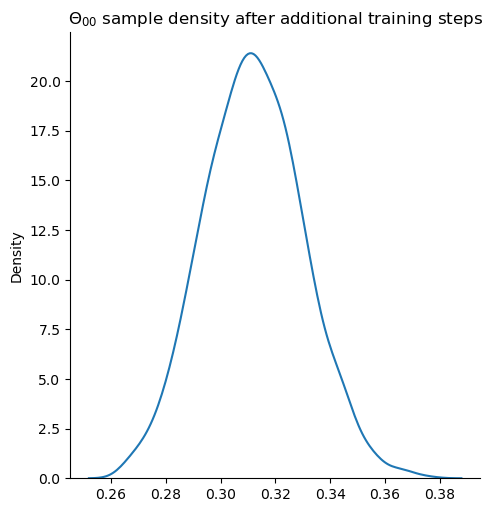

In [90]:
Theta_00 = samples[1][:, 0, 0].numpy()
_ = sns.displot(
    Theta_00, 
    kind="kde"
).set(
    title="$\Theta_{00}$ sample density after additional training steps"
)